In [247]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import Word, TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from warnings import filterwarnings

In [248]:
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 200)


In [249]:
df = pd.read_excel("C:\\Users\\Sariye\\Desktop\\miuul-ödev\\amazon.xlsx")

In [250]:
pd.options.display.max_rows = None

In [251]:
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [252]:
# if df['Review'].isna().any():
#     print(f"{'Review'} sütununda NaN değerleri var.")
# else:
#     print(f"{'Review'} sütununda NaN değeri yok.")

In [253]:
df['Review'][142]

"It's winter here in Minneapolis and at -23 deg f I love this view in my room haha!"

In [254]:
#büyük harfleri küçük harfe çevirme
df['Review'] = df['Review'].str.lower()

In [255]:

# Noktalama işaretlerini çıkarma
df['Review'] = df['Review'].str.replace('[^\w\s]', '', regex=True)


In [256]:
#nümerik ifadelerden arındırma
df['Review'] = df['Review'].str.replace('\d', '',regex=True)

In [257]:
df['Review'][142]

'its winter here in minneapolis and at  deg f i love this view in my room haha'

In [258]:
#stopwords ifadelerden arındırma
sw = stopwords.words('english')

df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [259]:
# e. 1000'den az geçen kelimeleri çıkarma
temp_df = pd.Series(' '.join(df['Review']).split()).value_counts()

drops = temp_df[temp_df < 1000]

df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

In [260]:
# Lemmatization,kelimenin kök halini alma işlemidir. 
df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [261]:
df['Review'].head(10)

0                           
1                           
2                           
3                           
4                           
5                           
6                           
7                    curtain
8                           
9    curtain curtain curtain
Name: Review, dtype: object

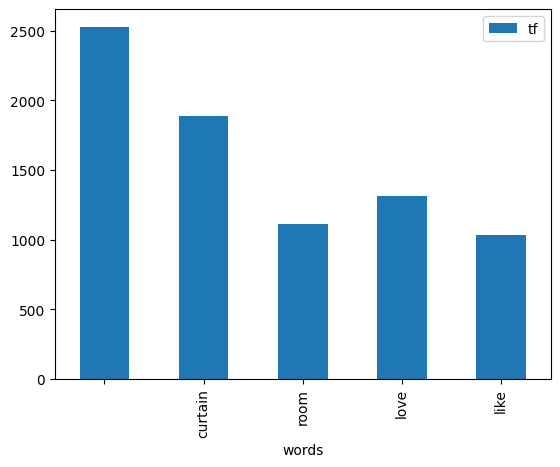

In [262]:
# Terim Frekanslarının Hesaplanması
###############################

tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

tf.columns = ["words", "tf"]

tf.sort_values("tf", ascending=False)


tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

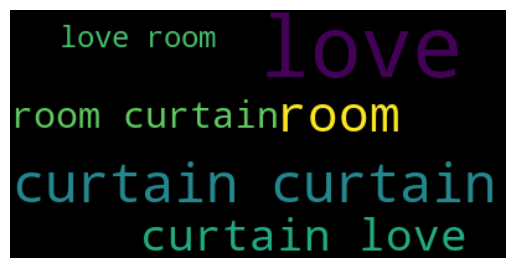

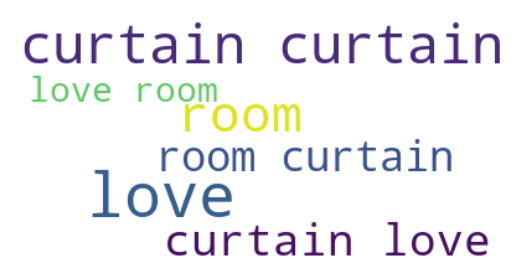

In [263]:
# Wordcloud
###############################

text = " ".join(i for i in df.Review)

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud.png")


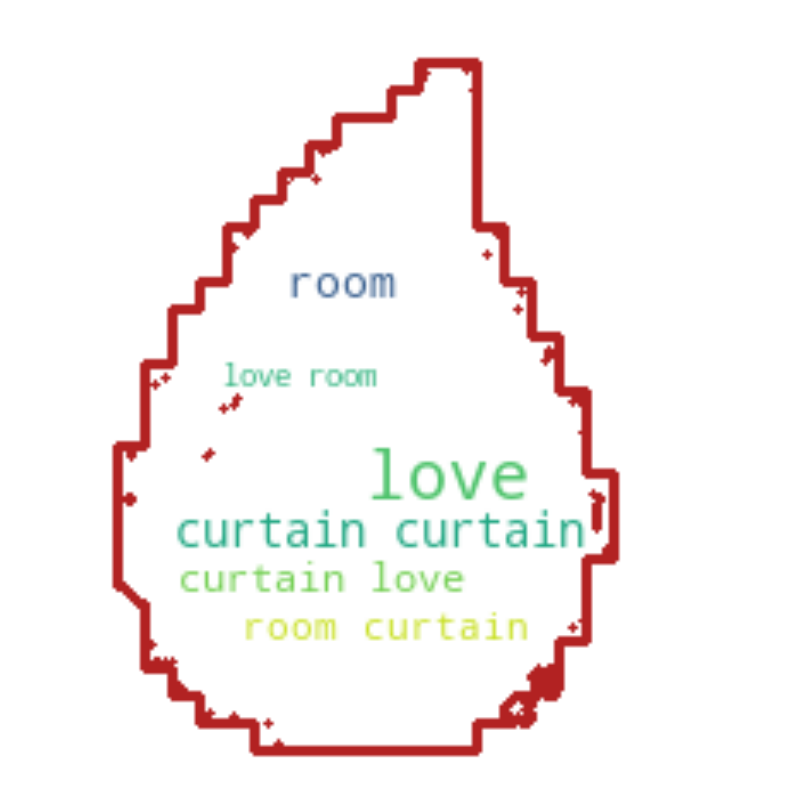

In [264]:
tr_mask = np.array(Image.open("su.jpeg"))

wc = WordCloud(background_color="white",
               max_words=1000,
               mask=tr_mask,
               contour_width=3,
               contour_color="firebrick")

wc.generate(text)
plt.figure(figsize=[10, 10])
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [265]:
sia = SentimentIntensityAnalyzer()

df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))

df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

#df["polarity_score"] = df["Review"].apply(lambda x: sia.polarity_scores(x)["compound"])


df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

df["sentiment_label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

#df["sentiment_label"].value_counts()

df.groupby("sentiment_label")["Star"].mean()

sentiment_label
neg   4.40
pos   4.42
Name: Star, dtype: float64

In [266]:
# Adım 1: Bağımlı ve bağımsız değişkenlerimizi belirleyerek datayı train test olara ayırınız.

# Test-Train
train_x,test_x,train_y,test_y = train_test_split(df['Review'],
                                                df['sentiment_label'],
                                                random_state=42)

In [267]:
# Adım 2: Makine öğrenmesi modeline verileri verebilmemiz için temsil şekillerini sayısala çevirmemiz gerekmekte.
           # a. TfidfVectorizer kullanarak bir nesne oluşturunuz.
           # b. Daha önce ayırmış olduğumuz train datamızı kullanarak oluşturduğumuz nesneye fit ediniz.
           # c. Oluşturmuş olduğumuz vektörü train ve test datalarına transform işlemini uygulayıp kaydediniz.

# TF-IDF Word Level
tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)


In [268]:
print("Eğitim veri seti boyutu:", x_train_tf_idf_word.shape)
print("Test veri seti boyutu:", test_y.shape)

Eğitim veri seti boyutu: (4208, 4)
Test veri seti boyutu: (1403,)


In [269]:
log_model = LogisticRegression().fit(x_train_tf_idf_word,train_y)

In [270]:
y_pred = log_model.predict(x_test_tf_idf_word)
print(classification_report(y_pred,test_y))
cross_val_score(log_model,x_test_tf_idf_word,test_y,cv=5).mean()

              precision    recall  f1-score   support

         neg       1.00      0.99      1.00       955
         pos       0.98      1.00      0.99       448

    accuracy                           1.00      1403
   macro avg       0.99      1.00      0.99      1403
weighted avg       1.00      1.00      1.00      1403



0.9942958820538891

In [271]:
random_review = pd.Series(df['Review'].sample(1).values)
new_review = CountVectorizer().fit(train_x).transform(random_review)
pred = log_model.predict(new_review)
print(f'Review: {random_review[0]} \n Prediction: {pred}')

Review: like room room 
 Prediction: ['pos']


In [272]:
rf_model = RandomForestClassifier().fit(x_train_tf_idf_word , train_y)
cross_val_score(rf_model,x_test_tf_idf_word,test_y ,cv=5,n_jobs=1).mean()

1.0